# Multilingual Universal Sentence Encoder
The model is intented to be used for text classification, text clustering, semantic textural similarity retrieval, cross-lingual text retrieval, etc.  
Convolutional Neural Net.  
This specific module is optimized for multi-word length text, such as sentences, phrases or short paragraphs.  

## Caricamento del modello

In [5]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
import tensorflow_text
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder-multilingual/3 loaded


## Importo il dataset 

In [6]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import numpy as np

#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
vax_series = pd.read_csv('data/posts_ULTRAcleaned_it_snowball.csv')
vax_series.dropna(inplace=True)

#salviamo una lista di lista con le parole tokenizzate
vax_text = vax_series['clean_text'].tolist()



## Pulizia

In [7]:
import spacy
import pandas as pd
import regex as re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
it_stopwords = stopwords.words('italian')

#the stemmer requires a language parameter
snow_stemmer = SnowballStemmer(language='italian')

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()
    #remving multiple spaces
    s = " ".join(s.split()).strip()
    #some manual corrections
    #s = s.replace(' accino', ' vaccino')
    #removing stopwords with nltk
    s = stop_word_remover(s)
    #stemming with nltk
    s = stemmer(s)

    return s


def stop_word_remover(text):
    word_tokens = word_tokenize(text)
    word_list = [word for word in word_tokens if word.lower() not in it_stopwords]
    return " ".join(word_list)

def stemmer(text):
    words = word_tokenize(text)
    stem_words = [snow_stemmer.stem(word) for word in words]
    return " ".join(stem_words)

query = "Secondo tutte le leggi conosciute dell’aeronautica, non c’è modo che un ape sia in grado di volare. Le sue ali sono troppo piccole per sollevare il suo corpicino grassoccio da terra. L’ape, si sa, vola lo stesso. Perché alle api non interessa quello che gli uomini ritengono impossibile"
#query = "vaccino pfizer lanciato sul mercato: 1 morto e 3 feriti"
#query=cleaner(query)

print(query)


Secondo tutte le leggi conosciute dell’aeronautica, non c’è modo che un ape sia in grado di volare. Le sue ali sono troppo piccole per sollevare il suo corpicino grassoccio da terra. L’ape, si sa, vola lo stesso. Perché alle api non interessa quello che gli uomini ritengono impossibile


## Embedding

Vettorizziamo tutto il dataset di partenza. Per ogni frase viene prodotto un vettore a 512 dimensioni. A causa di un crash dovuto alla memoria non si può elaborare tutto il dataset ma solamente batch di 1000 frasi alla volta.

In [8]:
#Vettorizza a 512 dimensioni ogni frase
sentences_number = len(vax_text)
BATCH_SIZE = 1000

start = 0
stop = BATCH_SIZE
sentence_vector: np.ndarray = np.zeros((sentences_number, 512))
while sentences_number > 0:
    print("Processing sentences from {} to {}".format(start, stop))
    sentence_embeddings = model(vax_text[start:stop])
    sentence_vector[start:stop] = sentence_embeddings

    processed = stop - start
    sentences_number -= processed

    start = stop

    if sentences_number < BATCH_SIZE:
        stop += sentences_number
    else:
        stop += BATCH_SIZE

print("Shape of sentence vector: ", sentence_vector.shape)

Processing sentences from 0 to 1000
Processing sentences from 1000 to 2000
Processing sentences from 2000 to 3000
Processing sentences from 3000 to 4000
Processing sentences from 4000 to 5000
Processing sentences from 5000 to 6000
Processing sentences from 6000 to 7000
Processing sentences from 7000 to 8000
Processing sentences from 8000 to 9000
Processing sentences from 9000 to 10000
Processing sentences from 10000 to 11000
Processing sentences from 11000 to 12000
Processing sentences from 12000 to 13000
Processing sentences from 13000 to 14000
Processing sentences from 14000 to 15000
Processing sentences from 15000 to 16000
Processing sentences from 16000 to 17000
Processing sentences from 17000 to 18000
Processing sentences from 18000 to 19000
Processing sentences from 19000 to 19103
Shape of sentence vector:  (19103, 512)


## Clusterizzazione kmeans degli embedding

In [9]:
import numpy as np
# k-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine, euclidean
from sklearn import preprocessing  # to normalise existing X

#create a numpy array with all the vectors
'''
vectors = np.zeros((len(sentence_embeddings), 512))
for i in range(len(sentence_embeddings)):
    vectors[i] = sentence_embeddings[i]
'''
vectors = sentence_vector
#normalize
vectors = preprocessing.normalize(vectors)

X_train = pd.DataFrame(vectors)

n_clusters = 1
n_init = 10
max_iter = 3000
tol = 0.0001
random_state = 2018
# n_jobs = 2

kmeansfirst = KMeans(n_clusters=n_clusters, n_init=n_init, \
    max_iter=max_iter, tol=tol, random_state=random_state )
   
kmeansfirst.fit(X_train)

center = kmeansfirst.cluster_centers_


print(kmeansfirst.score(vectors))

#calculate the distance between each point and the center
X_train['distance'] = X_train.apply(lambda x: cosine(x, center[0]), axis=1)

-12250.709788227694


## Calcolo della distanza degli embedding dal centro del cluster

In [10]:
X_train["distance"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    19103.000000
mean         0.401082
std          0.130405
min          0.148312
25%          0.316737
50%          0.373056
75%          0.446990
90%          0.591787
95%          0.684434
99%          0.818100
max          0.969242
Name: distance, dtype: float64

# Frasi di prova per test

In [11]:
#calculating the distance from the center
from gensim import similarities
from scipy.spatial.distance import cosine, euclidean
import spacy
import pandas as pd
import regex as re
import numpy as np


#definiziamo una lista di frasi che dovrebbero essere classificate come anomalie
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi", "una frase che parla di tutt'altro ma il modo lunghissimo per tentare di ingannare il caro amico use" ]
novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al vaccino", "non farò mai il booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]
#provo con un testo casuale
#testo = "i vaccini fanno morire le persone anche se ci dicono di no"
#test_vector = sbert_model.encode([anomalies])
#test_vector = model(testo)

cosine_distance = []
euclidean_distance = []
'''cosine_distance.append(  cosine(test_vector[0],center[0]) )
cosine_distance.append(  cosine(test_vector[0],center[1]) )
euclidean_distance.append (euclidean(test_vector[0],center[0]))
euclidean_distance.append(euclidean(test_vector[0],center[1]))

print("Distance score cosine 1 - 2:",cosine_distance[0],cosine_distance[1])
print("Distance score euclidean 1 - 2:",euclidean_distance[0],euclidean_distance[1])
print ("Euclidean distance sum:",sum(euclidean_distance))'''

print("Anomalies score:")
for i in anomalies:
   
    test_vector = model([cleaner(i)])
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center[0])
    euclidean_distance = euclidean(test_vector[0],center[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)


print("Novax score:")
for i in novax_sentences:
    test_vector = model([cleaner(i)])
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center[0])
    euclidean_distance = euclidean(test_vector[0],center[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)
    #print ("Cosine norm:",cosine_distance_norm,"Euclidean norm: ",cosine_distance_norm)

Anomalies score:
Cosine: 0.8246393201363268
Cosine: 0.8033370532187187
Cosine: 0.8438325946890375
Cosine: 0.6470363011629183
Novax score:
Cosine: 0.3714880982005636
Cosine: 0.4542975200789947
Cosine: 0.38014482710314745
Cosine: 0.7577016981975305
Cosine: 0.6228286907406456
Cosine: 0.3300879555181917


 ## Visualizzazione cluster con PCA

In [16]:
#Importing required modules
 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
data = sentence_vector
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(data)
 
df.shape

#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 1)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
print(label)



/home/apsev/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 ... 0 0 0]


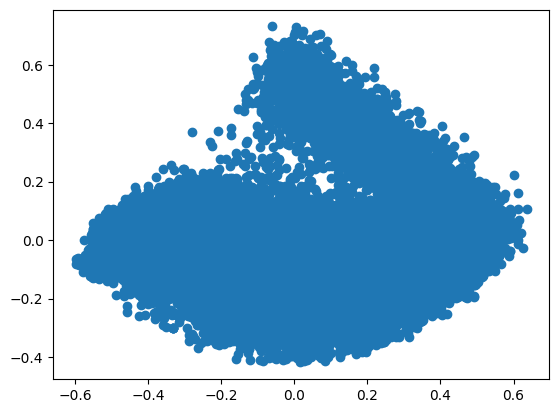

In [17]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = df[label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

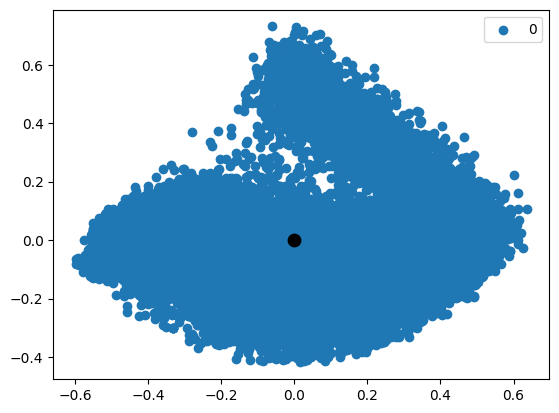

In [18]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [15]:
#TODO: controllare lo score del cluster per vedere quanto è sparso 
# quante feature perdiamo utilizzando la PCA???? Rimane comunque significatvio???? 